# Modeling

In [49]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install keras-tuner
!pip install scikit-learn
!pip install xgboost

In [51]:
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import Bidirectional, SimpleRNN, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

from kerastuner.tuners import RandomSearch

# import xgboost as xgb

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
# Check if GPU is available
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

No GPU found


## Load the Data

In [125]:
# Read in Parquet File
df_final = pd.read_parquet('02_Clean_Data\/df_final.parquet')

## Data Preparation

In [126]:
# Shuffle Rows of Data
df_final = df_final.sample(frac=1, random_state=42).reset_index(drop=True)

In [127]:
# Drop Non Numerical Columns
df_final = df_final.drop(['ID', 'Date', 'Ticker',
                          'Stock Ticker'], axis=1)

In [128]:
# Scale the dataframe
scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df_final),
                         columns=df_final.columns)

In [58]:
# Create a list of dataframes that will be stacked and converted
# to a TensorFlow Tensor
df_list = []
for i in range(0, 29):
    try:
        price_col = 'Price-' + str(i)
        rate_col = 'rate-' + str(i)
        div_col = 'Dividends-' + str(i)
        cols_filter = ['Close', 'Call', 'Days to Expiration',
                    'strike', price_col, rate_col, div_col]
        temp = scaled_df[cols_filter]
        df_list.append(temp)
    except:
        pass

In [59]:
# Preview the first dataframe in the List
df_list[0].head()

,Close,Call,Days to Expiration,strike,Price-0,rate-0,Dividends-0
0,0.001727,0.0,0.366460,0.142474,0.314285,0.662162,0.118085
1,0.011006,1.0,0.062112,0.038410,0.057659,0.589681,0.042693
2,0.024426,0.0,0.282609,0.169272,0.239672,0.570639,0.200491
3,0.012671,0.0,0.341615,0.115677,0.173466,0.754914,0.273253
4,0.005867,1.0,0.456522,0.075480,0.080304,0.707617,0.270623


In [60]:
# assume each dataframe has the same number of columns
n_features = len(df_list[0].columns)

# convert the dataframes into numpy arrays
df_array_list = [df.to_numpy() for df in df_list]

# stack the numpy arrays along the new time step dimension
tensor_data = np.stack(df_array_list, axis=1)

# create a TensorFlow tensor from the numpy array
tensor = tf.convert_to_tensor(tensor_data, dtype=tf.float32)

# print the shape of the tensor
tensor.shape

TensorShape([375342, 20, 7])

In [61]:
# Preview the First 5 Observations of the First Layer of the Tensor
pd.DataFrame(tensor[0][0:5])

,0,1,2,3,4,5,6
0,0.001727,0.0,0.36646,0.142474,0.314285,0.662162,0.118085
1,0.001727,0.0,0.36646,0.142474,0.314590,0.662162,0.118085
2,0.001727,0.0,0.36646,0.142474,0.314590,0.662162,0.118085
3,0.001727,0.0,0.36646,0.142474,0.320258,0.662162,0.118085
4,0.001727,0.0,0.36646,0.142474,0.331029,0.662162,0.118085


In [62]:
# Print the Number of Observations, Timesteps, and Input Dimension
observations = len(tensor)
timesteps = len(tensor[0])
input_dim = len(tensor[0][0])

print('Observations: %d' % (observations))
print('Timesteps: %d' % (timesteps))
print('Input Dimension: %d' % (input_dim))

Observations: 375342
Timesteps: 20
Input Dimension: 7


In [63]:
# Split the data into Training, Validation, and Test Sets
train_data = tensor[:int(0.98 * len(tensor))]
val_data = tensor[int(0.98 * len(tensor)):int(0.99 * len(tensor))]
test_data = tensor[int(0.99 * len(tensor)):]

In [43]:
# Save the Training, Validation, and Test Sets as .npy Files
np.save('03_Data_Splits\/train_data.npy', train_data)
np.save('03_Data_Splits\/val_data.npy', val_data)
np.save('03_Data_Splits\/test_data.npy', test_data)

## Model 1: Simple Recurrent Neural Network

In [15]:
def build_model(hp):
    model = Sequential()
    model.add(SimpleRNN(units=hp.Int('units', min_value=32, max_value=256, step=32), input_shape=(20, 6)))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='mean_squared_error')
    return model

# Create the tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='',
    project_name='04_Hyperparameter_Tuning\/RNN_01_hyperparameter_tuning')

# Perform the hyperparameter tuning
tuner.search(train_data[:, :, 1:], train_data[:, :, 0],
             validation_data=(val_data[:, :, 1:], val_data[:, :, 0]),
             epochs=10,
             batch_size=128)

# Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Train the best model
best_model.fit(train_data[:, :, 1:], train_data[:, :, 0], validation_data=(val_data[:, :, 1:],
                                                                          val_data[:, :, 0]), epochs=1, batch_size=128)

# Evaluate the best model on the test set
test_loss = best_model.evaluate(test_data[:, :, 1:], test_data[:, :, 0])
print('Test loss:', test_loss)

# Save the best model
best_model.save('05_Models\/RNN_01_best_model.h5')

Trial 10 Complete [00h 14m 30s]
val_loss: 3.95700565907949e-05

Best val_loss So Far: 2.721390592341777e-05
Total elapsed time: 02h 28m 34s
118/118 [==============================] - 0s 3ms/step - loss: 4.8133e-05
Test loss: 4.81331990158651e-05


In [16]:
# Load the best model
best_model = load_model('05_Models\/RNN_01_best_model.h5')

# Make Predictions on the Test Set
predictions = best_model.predict(test_data[:, :, 1:])

# Create a DataFrame of the Predictions and True Values
true_prices = test_data[:, :, 0]
predicted_list = []
true_list = []

for i in range(len(test_data)):
    predicted_list.append(predictions[i][0])
    true_list.append(true_prices[i][0].numpy())

results = pd.DataFrame(list(zip(predicted_list, true_list)), columns=['Predicted', 'True'])

# Manually Scale the Data back to the Original Scale from df_final
results['Predicted'] = results['Predicted'] * (df_final['Close'].max() - df_final['Close'].min()) + df_final['Close'].min()
results['True'] = results['True'] * (df_final['Close'].max() - df_final['Close'].min()) + df_final['Close'].min()

# Create a Column of the Difference Between the Predicted and True Values
results['Difference'] = results['Predicted'] - results['True']

# Create a Column for Absolute Error
results['Absolute Error'] = abs(results['Difference'])

# Create a Column for Absolute Percentage Error
results['Absolute Percentage Error'] = abs(results['Difference'] / results['True'])

# Drop the Difference Column
results = results.drop(columns=['Difference'])

# Sort them by True Values Descending
results = results.sort_values(by='True', ascending=False)

# Save the Results to a CSV File
results.to_csv('06_Testing_Results\/RNN_01_results.csv', index=False)

# Preview the First 10 Results Sorted by True Values in Descending Order
results.head()

118/118 [==============================] - 1s 3ms/step


,Predicted,True,Absolute Error,Absolute Percentage Error
2541,215.629440,257.059998,41.430557,0.161171
2716,169.537384,185.600006,16.062622,0.086544
2434,118.331711,128.350006,10.018295,0.078054
1234,108.459419,114.000000,5.540581,0.048602
2795,99.133865,109.610001,10.476135,0.095576


In [17]:
# Preview the Last 10 Results Sorted by True Values in Descending Order
results.tail()

,Predicted,True,Absolute Error,Absolute Percentage Error
1740,1.045332,0.01,1.035332,103.533226
1462,0.541489,0.01,0.531489,53.148872
1315,0.871510,0.01,0.861510,86.150993
1571,-1.496570,0.01,1.506570,150.657028
1404,2.689227,0.01,2.679227,267.922729


In [18]:
# Print Mean Absolute Error
print('Mean Absolute Error:', round(results['Absolute Error'].mean(), 2))

Mean Absolute Error: 2.61


In [19]:
# Print Mean Absolute Percentage Error
print('Mean Absolute Percentage Error:', round(results['Absolute Percentage Error'].mean(), 2), '%')

Mean Absolute Percentage Error: 7.05 %


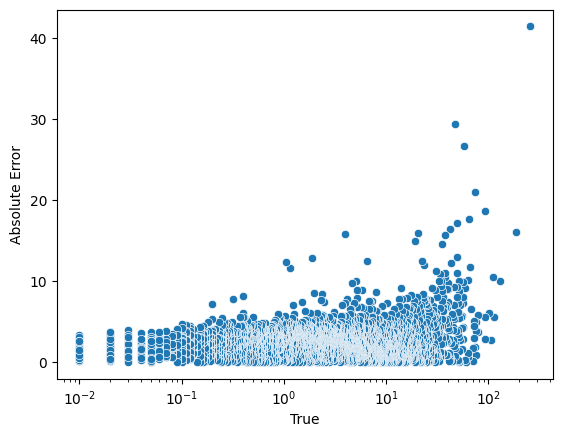

In [20]:
sns.scatterplot(x='True', y='Absolute Error', data=results)
plt.xscale('log')

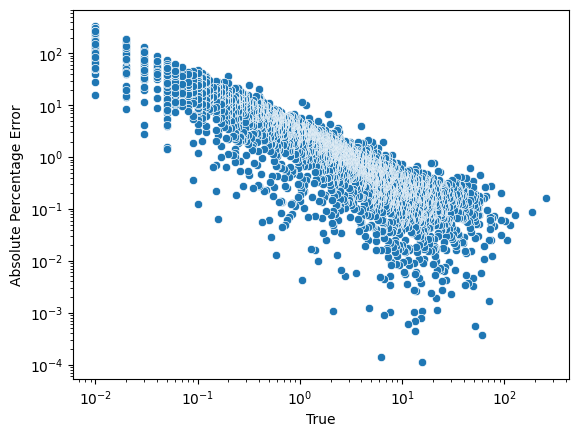

In [21]:
sns.scatterplot(x='True', y='Absolute Percentage Error', data=results)
plt.xscale('log')
plt.yscale('log')

## Model 2: Standard LSTM

In [ ]:
# Define the LSTM Model
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=256, step=32), input_shape=(20, 6)))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='mean_squared_error')
    return model

# Create the tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='',
    project_name='04_Hyperparameter_Tuning\/lstm_01_hyperparameter_tuning')

# Perform the hyperparameter tuning
tuner.search(train_data[:, :, 1:], train_data[:, :, 0],
             validation_data=(val_data[:, :, 1:], val_data[:, :, 0]),
             epochs=10,
             batch_size=128)

# Get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Rebuild the best model using the best hyperparameters
best_model = build_model(best_hyperparameters)

# Train the best model
best_model.fit(train_data[:, :, 1:], train_data[:, :, 0], validation_data=(val_data[:, :, 1:],
                                                                          val_data[:, :, 0]), epochs=1, batch_size=128)

# Evaluate the best model on the test set
test_loss = best_model.evaluate(test_data[:, :, 1:], test_data[:, :, 0])
print('Test loss:', test_loss)

# Save the best model
best_model.save('05_Models\/lstm_01_best_model.h5')

Trial 10 Complete [00h 06m 02s]
val_loss: 3.0462577948734786e-05

Best val_loss So Far: 1.5203299274920331e-05
Total elapsed time: 00h 57m 21s
118/118 [==============================] - 0s 2ms/step - loss: 1.4763e-04
Test loss: 0.00014763057697564363


In [ ]:
# Load the best model
best_model = load_model('05_Models\/lstm_01_best_model.h5')

# Make Predictions on the Test Set
predictions = best_model.predict(test_data[:, :, 1:])

# Create a DataFrame of the Predictions and True Values
true_prices = test_data[:, :, 0]
predicted_list = []
true_list = []

for i in range(len(test_data)):
    predicted_list.append(predictions[i][0])
    true_list.append(true_prices[i][0].numpy())

results = pd.DataFrame(list(zip(predicted_list, true_list)), columns=['Predicted', 'True'])

# Manually Scale the Data back to the Original Scale from df_final
results['Predicted'] = results['Predicted'] * (df_final['Close'].max() - df_final['Close'].min()) + df_final['Close'].min()
results['True'] = results['True'] * (df_final['Close'].max() - df_final['Close'].min()) + df_final['Close'].min()

# Create a Column of the Difference Between the Predicted and True Values
results['Difference'] = results['Predicted'] - results['True']

# Create a Column for Absolute Error
results['Absolute Error'] = abs(results['Difference'])

# Create a Column for Absolute Percentage Error
results['Absolute Percentage Error'] = abs(results['Difference'] / results['True'])

# Drop the Difference Column
results = results.drop(columns=['Difference'])

# Sort them by True Values Descending
results = results.sort_values(by='True', ascending=False)

# Save the Results to a CSV File
results.to_csv('06_Testing_Results\/lstm_01_results.csv', index=False)

# Preview the First 10 Results Sorted by True Values in Descending Order
results.head()

118/118 [==============================] - 1s 2ms/step


,Predicted,True,Absolute Error,Absolute Percentage Error
2541,132.050552,257.059998,125.009445,0.486305
2716,118.533623,185.600006,67.066383,0.361349
2434,103.421524,128.350006,24.928482,0.194223
1234,83.266464,114.000000,30.733536,0.269592
2795,97.705536,109.610001,11.904465,0.108607


In [ ]:
# Preview the Last 10 Results Sorted by True Values in Descending Order
results.tail()

,Predicted,True,Absolute Error,Absolute Percentage Error
1740,-3.171011,0.01,3.181011,318.101105
1462,-3.047535,0.01,3.057535,305.753479
1315,-2.058816,0.01,2.068816,206.881592
1571,-4.791250,0.01,4.801250,480.125000
1404,-1.085169,0.01,1.095169,109.516922


In [ ]:
# Print Mean Absolute Error
print('Mean Absolute Error:', round(results['Absolute Error'].mean(), 2))

Mean Absolute Error: 2.97


In [ ]:
# Print Mean Absolute Percentage Error
print('Mean Absolute Percentage Error:', round(results['Absolute Percentage Error'].mean(), 2), '%')

Mean Absolute Percentage Error: 7.47 %


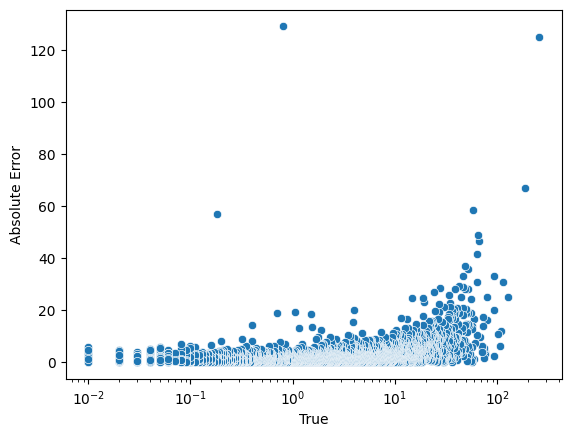

In [ ]:
sns.scatterplot(x='True', y='Absolute Error', data=results)
plt.xscale('log')

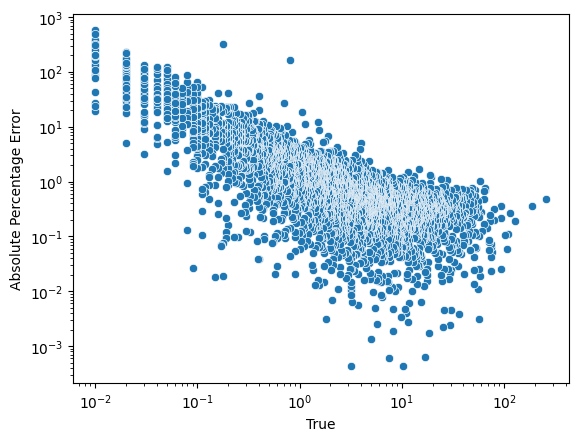

In [ ]:
sns.scatterplot(x='True', y='Absolute Percentage Error', data=results)
plt.xscale('log')
plt.yscale('log')

## Model 3: Stacked LSTM with 2 Layers

In [27]:
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units_1', min_value=32, max_value=256, step=32), input_shape=(20, 6), return_sequences=True))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units_2', min_value=32, max_value=256, step=32)))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='mean_squared_error')
    return model

# Create the tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='',
    project_name='04_Hyperparameter_Tuning\/lstm_02_hyperparameter_tuning')

# Perform the hyperparameter tuning
tuner.search(train_data[:, :, 1:], train_data[:, :, 0],
             validation_data=(val_data[:, :, 1:], val_data[:, :, 0]),
             epochs=10,
             batch_size=128)

# Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Train the best model
best_model.fit(train_data[:, :, 1:], train_data[:, :, 0], validation_data=(val_data[:, :, 1:],
                                                                          val_data[:, :, 0]), epochs=1, batch_size=128)

# Evaluate the best model on the test set
test_loss = best_model.evaluate(test_data[:, :, 1:], test_data[:, :, 0])
print('Test loss:', test_loss)

# Save the best model
best_model.save('05_Models\/lstm_02_best_model.h5')

Trial 10 Complete [00h 09m 17s]
val_loss: 3.147766437905375e-05

Best val_loss So Far: 1.9773968233494088e-05
Total elapsed time: 01h 27m 37s
118/118 [==============================] - 0s 3ms/step - loss: 3.5894e-05
Test loss: 3.5894368920708075e-05


In [28]:
# Load the best model
best_model = load_model('05_Models\/lstm_02_best_model.h5')

# Make Predictions on the Test Set
predictions = best_model.predict(test_data[:, :, 1:])

# Create a DataFrame of the Predictions and True Values
true_prices = test_data[:, :, 0]
predicted_list = []
true_list = []

for i in range(len(test_data)):
    predicted_list.append(predictions[i][0])
    true_list.append(true_prices[i][0].numpy())

results = pd.DataFrame(list(zip(predicted_list, true_list)), columns=['Predicted', 'True'])

# Manually Scale the Data back to the Original Scale from df_final
results['Predicted'] = results['Predicted'] * (df_final['Close'].max() - df_final['Close'].min()) + df_final['Close'].min()
results['True'] = results['True'] * (df_final['Close'].max() - df_final['Close'].min()) + df_final['Close'].min()

# Create a Column of the Difference Between the Predicted and True Values
results['Difference'] = results['Predicted'] - results['True']

# Create a Column for Absolute Error
results['Absolute Error'] = abs(results['Difference'])

# Create a Column for Absolute Percentage Error
results['Absolute Percentage Error'] = abs(results['Difference'] / results['True'])

# Drop the Difference Column
results = results.drop(columns=['Difference'])

# Sort them by True Values Descending
results = results.sort_values(by='True', ascending=False)

# Save the Results to a CSV File
results.to_csv('06_Testing_Results\/lstm_02_results.csv', index=False)

# Preview the First 10 Results Sorted by True Values in Descending Order
results.head()

118/118 [==============================] - 1s 2ms/step


,Predicted,True,Absolute Error,Absolute Percentage Error
2541,212.309433,257.059998,44.750565,0.174086
2716,177.724091,185.600006,7.875916,0.042435
2434,130.494629,128.350006,2.144623,0.016709
1234,95.347382,114.000000,18.652618,0.163619
2795,120.092415,109.610001,10.482414,0.095634


In [29]:
# Preview the Last 10 Results Sorted by True Values in Descending Order
results.tail()

,Predicted,True,Absolute Error,Absolute Percentage Error
1740,-1.122598,0.01,1.132598,113.259773
1462,-1.318580,0.01,1.328580,132.858032
1315,-1.287080,0.01,1.297080,129.707962
1571,-0.851119,0.01,0.861119,86.111893
1404,0.034171,0.01,0.024171,2.417095


In [30]:
# Print Mean Absolute Error
print('Mean Absolute Error:', round(results['Absolute Error'].mean(), 2))

Mean Absolute Error: 1.74


In [31]:
# Print Mean Absolute Percentage Error
print('Mean Absolute Percentage Error:', round(results['Absolute Percentage Error'].mean(), 2), '%')

Mean Absolute Percentage Error: 2.97 %


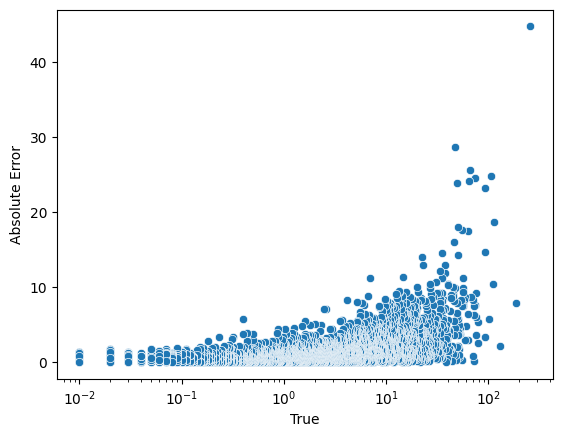

In [32]:
sns.scatterplot(x='True', y='Absolute Error', data=results)
plt.xscale('log')

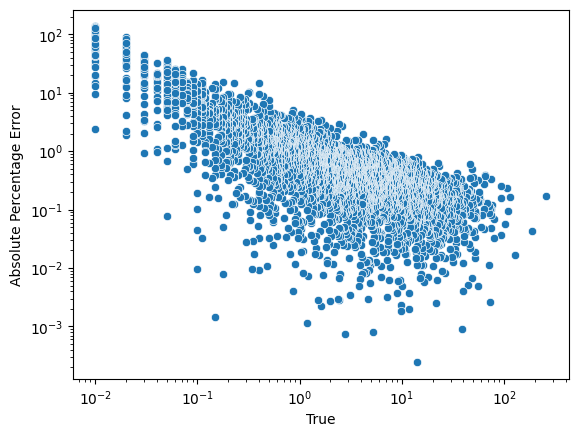

In [33]:
sns.scatterplot(x='True', y='Absolute Percentage Error', data=results)
plt.xscale('log')
plt.yscale('log')

## Model 4: Stacked LSTM with 4 Layers

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units_1', min_value=32, max_value=256, step=32), input_shape=(20, 6), return_sequences=True))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units_2', min_value=32, max_value=256, step=32), return_sequences=True))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units_3', min_value=32, max_value=256, step=32), return_sequences=True))
    model.add(Dropout(hp.Float('dropout_3', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units_4', min_value=32, max_value=256, step=32)))
    model.add(Dropout(hp.Float('dropout_4', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='mean_squared_error')
    return model

# Create the tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='',
    project_name='04_Hyperparameter_Tuning\/lstm_03_hyperparameter_tuning')

# Perform the hyperparameter tuning
tuner.search(train_data[:, :, 1:], train_data[:, :, 0],
             validation_data=(val_data[:, :, 1:], val_data[:, :, 0]),
             epochs=10,
             batch_size=128)

# Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Train the best model
best_model.fit(train_data[:, :, 1:], train_data[:, :, 0], validation_data=(val_data[:, :, 1:],
                                                                          val_data[:, :, 0]), epochs=1, batch_size=128)

# Evaluate the best model on the test set
test_loss = best_model.evaluate(test_data[:, :, 1:], test_data[:, :, 0])
print('Test loss:', test_loss)

# Save the best model
best_model.save('05_Models\/lstm_03_best_model.h5')

Trial 10 Complete [00h 13m 40s]
val_loss: 3.5520142167418577e-05

Best val_loss So Far: 1.8961359576981824e-05
Total elapsed time: 02h 16m 35s
118/118 [==============================] - 0s 4ms/step - loss: 2.2120e-04
Test loss: 0.00022120367793831974


In [ ]:
# Load the best model
best_model = load_model('05_Models\/lstm_03_best_model.h5')

# Make Predictions on the Test Set
predictions = best_model.predict(test_data[:, :, 1:])

# Create a DataFrame of the Predictions and True Values
true_prices = test_data[:, :, 0]
predicted_list = []
true_list = []

for i in range(len(test_data)):
    predicted_list.append(predictions[i][0])
    true_list.append(true_prices[i][0].numpy())

results = pd.DataFrame(list(zip(predicted_list, true_list)), columns=['Predicted', 'True'])

# Manually Scale the Data back to the Original Scale from df_final
results['Predicted'] = results['Predicted'] * (df_final['Close'].max() - df_final['Close'].min()) + df_final['Close'].min()
results['True'] = results['True'] * (df_final['Close'].max() - df_final['Close'].min()) + df_final['Close'].min()

# Create a Column of the Difference Between the Predicted and True Values
results['Difference'] = results['Predicted'] - results['True']

# Create a Column for Absolute Error
results['Absolute Error'] = abs(results['Difference'])

# Create a Column for Absolute Percentage Error
results['Absolute Percentage Error'] = abs(results['Difference'] / results['True'])

# Drop the Difference Column
results = results.drop(columns=['Difference'])

# Sort them by True Values Descending
results = results.sort_values(by='True', ascending=False)

# Save the Results to a CSV File
results.to_csv('06_Testing_Results\/lstm_03_results.csv', index=False)

# Preview the First 10 Results Sorted by True Values in Descending Order
results.head()

118/118 [==============================] - 2s 4ms/step


,Predicted,True,Absolute Error,Absolute Percentage Error
2541,152.572800,257.059998,104.487198,0.406470
2716,113.491341,185.600006,72.108665,0.388517
2434,52.322712,128.350006,76.027298,0.592344
1234,61.067780,114.000000,52.932220,0.464318
2795,63.620178,109.610001,45.989822,0.419577


In [ ]:
# Preview the Last 10 Results Sorted by True Values in Descending Order
results.tail()

,Predicted,True,Absolute Error,Absolute Percentage Error
1740,4.361207,0.01,4.351207,435.120728
1462,4.677115,0.01,4.667115,466.711487
1315,4.464442,0.01,4.454442,445.444214
1571,4.972969,0.01,4.962969,496.296906
1404,4.225525,0.01,4.215525,421.552490


In [ ]:
# Print Mean Absolute Error
print('Mean Absolute Error:', round(results['Absolute Error'].mean(), 2))

Mean Absolute Error: 4.71


In [ ]:
# Print Mean Absolute Percentage Error
print('Mean Absolute Percentage Error:', round(results['Absolute Percentage Error'].mean(), 2), '%')

Mean Absolute Percentage Error: 17.58 %


In [34]:
results = pd.read_csv("lstm_03_results.csv")

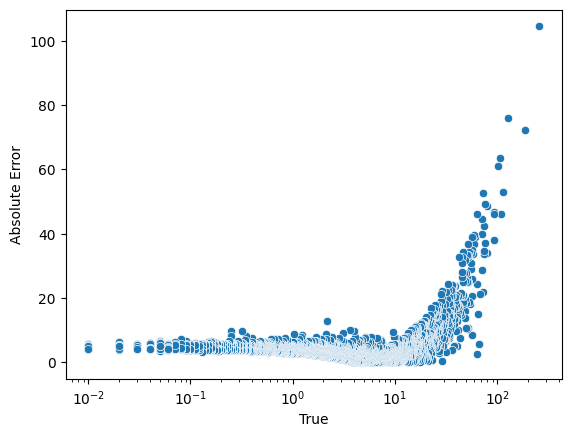

In [35]:
sns.scatterplot(x='True', y='Absolute Error', data=results)
plt.xscale('log')

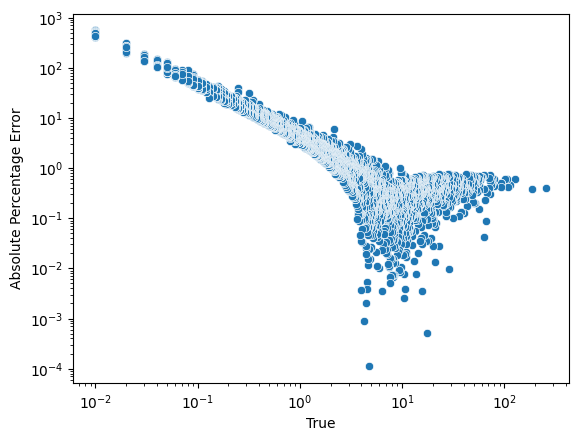

In [ ]:
sns.scatterplot(x='True', y='Absolute Percentage Error', data=results)
plt.xscale('log')
plt.yscale('log')

## Model 5: Bidirectional LSTM

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=32, max_value=256, step=32), input_shape=(20, 6))))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='mean_squared_error')
    return model

# Create the tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='',
    project_name='04_Hyperparameter_Tuning\/lstm_04_hyperparameter_tuning')

# Perform the hyperparameter tuning
tuner.search(train_data[:, :, 1:], train_data[:, :, 0],
             validation_data=(val_data[:, :, 1:], val_data[:, :, 0]),
             epochs=10,
             batch_size=128)

# Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Train the best model
best_model.fit(train_data[:, :, 1:], train_data[:, :, 0], validation_data=(val_data[:, :, 1:],
                                                                          val_data[:, :, 0]), epochs=1, batch_size=128)

# Evaluate the best model on the test set
test_loss = best_model.evaluate(test_data[:, :, 1:], test_data[:, :, 0])
print('Test loss:', test_loss)

# Save the best model
best_model.save('05_Models\/lstm_04_best_model.h5')

Trial 10 Complete [00h 08m 29s]
val_loss: 4.028409360519921e-05

Best val_loss So Far: 1.812646587495692e-05
Total elapsed time: 01h 23m 15s
118/118 [==============================] - 0s 3ms/step - loss: 2.2143e-05
Test loss: 2.2143380192574114e-05


In [ ]:
# Load the best model
best_model = load_model('05_Models\/lstm_04_best_model.h5')

# Make Predictions on the Test Set
predictions = best_model.predict(test_data[:, :, 1:])

# Create a DataFrame of the Predictions and True Values
true_prices = test_data[:, :, 0]
predicted_list = []
true_list = []

for i in range(len(test_data)):
    predicted_list.append(predictions[i][0])
    true_list.append(true_prices[i][0].numpy())

results = pd.DataFrame(list(zip(predicted_list, true_list)), columns=['Predicted', 'True'])

# Manually Scale the Data back to the Original Scale from df_final
results['Predicted'] = results['Predicted'] * (df_final['Close'].max() - df_final['Close'].min()) + df_final['Close'].min()
results['True'] = results['True'] * (df_final['Close'].max() - df_final['Close'].min()) + df_final['Close'].min()

# Create a Column of the Difference Between the Predicted and True Values
results['Difference'] = results['Predicted'] - results['True']

# Create a Column for Absolute Error
results['Absolute Error'] = abs(results['Difference'])

# Create a Column for Absolute Percentage Error
results['Absolute Percentage Error'] = abs(results['Difference'] / results['True'])

# Drop the Difference Column
results = results.drop(columns=['Difference'])

# Sort them by True Values Descending
results = results.sort_values(by='True', ascending=False)

# Save the Results to a CSV File
results.to_csv('06_Testing_Results\/lstm_04_results.csv', index=False)

# Preview the First 10 Results Sorted by True Values in Descending Order
results.head()

118/118 [==============================] - 1s 2ms/step


,Predicted,True,Absolute Error,Absolute Percentage Error
2541,252.770798,257.059998,4.289200,0.016686
2716,189.463516,185.600006,3.863510,0.020816
2434,123.070892,128.350006,5.279114,0.041131
1234,112.325996,114.000000,1.674004,0.014684
2795,112.880981,109.610001,3.270981,0.029842


In [ ]:
# Preview the Last 10 Results Sorted by True Values in Descending Order
results.tail()

,Predicted,True,Absolute Error,Absolute Percentage Error
1740,0.117754,0.01,0.107754,10.775371
1462,0.441976,0.01,0.431976,43.197590
1315,-0.308386,0.01,0.318386,31.838596
1571,-0.404669,0.01,0.414669,41.466915
1404,-0.351632,0.01,0.361632,36.163246


In [ ]:
# Print Mean Absolute Error
print('Mean Absolute Error:', round(results['Absolute Error'].mean(), 2))

Mean Absolute Error: 1.31


In [ ]:
# Print Mean Absolute Percentage Error
print('Mean Absolute Percentage Error:', round(results['Absolute Percentage Error'].mean(), 2), '%')

Mean Absolute Percentage Error: 1.89 %


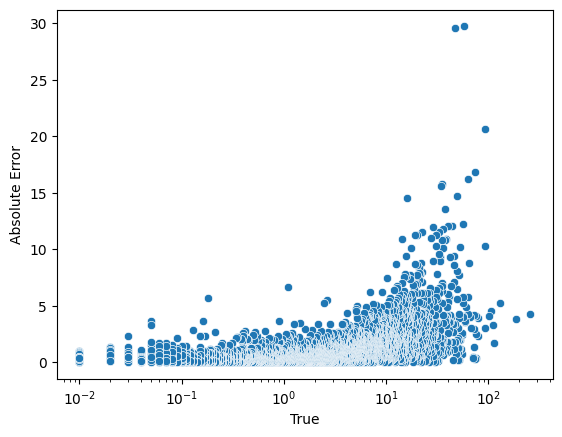

In [ ]:
sns.scatterplot(x='True', y='Absolute Error', data=results)
plt.xscale('log')

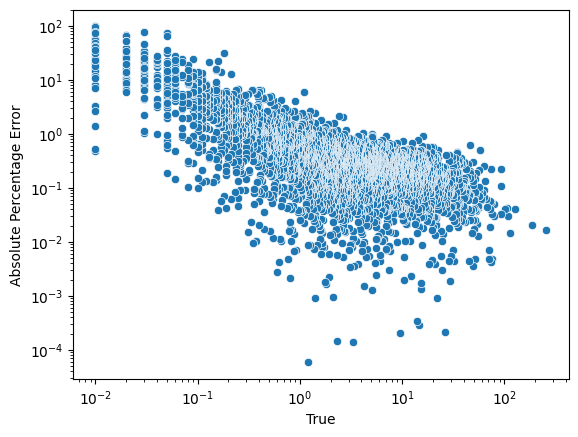

In [ ]:
sns.scatterplot(x='True', y='Absolute Percentage Error', data=results)
plt.xscale('log')
plt.yscale('log')

In [ ]:
sns.scatterplot(x='True', y='Absolute Percentage Error', data=results)
plt.xscale('log')
plt.yscale('log')

## Model 6: Gated Recurrent Unit

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(GRU(units=hp.Int('units', min_value=32, max_value=256, step=32), input_shape=(20, 6)))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='mean_squared_error')
    return model

# Create the tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='',
    project_name='04_Hyperparameter_Tuning\/GRU_hyperparameter_tuning')

# Perform the hyperparameter tuning
tuner.search(train_data[:, :, 1:], train_data[:, :, 0],
             validation_data=(val_data[:, :, 1:], val_data[:, :, 0]),
             epochs=10,
             batch_size=128)

# Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Train the best model
best_model.fit(train_data[:, :, 1:], train_data[:, :, 0], validation_data=(val_data[:, :, 1:],
                                                                          val_data[:, :, 0]), epochs=1, batch_size=128)

# Evaluate the best model on the test set
test_loss = best_model.evaluate(test_data[:, :, 1:], test_data[:, :, 0])
print('Test loss:', test_loss)

# Save the best model
best_model.save('05_Models\/GRU_best_model.h5')

Trial 10 Complete [00h 05m 37s]
val_loss: 1.804970149047828e-05

Best val_loss So Far: 1.5343208967048366e-05
Total elapsed time: 00h 55m 53s
118/118 [==============================] - 0s 2ms/step - loss: 1.3577e-05
Test loss: 1.3576974197349045e-05


In [ ]:
# Load the best model
best_model = load_model('05_Models\/GRU_best_model.h5')

# Make Predictions on the Test Set
predictions = best_model.predict(test_data[:, :, 1:])

# Create a DataFrame of the Predictions and True Values
true_prices = test_data[:, :, 0]
predicted_list = []
true_list = []

for i in range(len(test_data)):
    predicted_list.append(predictions[i][0])
    true_list.append(true_prices[i][0].numpy())

results = pd.DataFrame(list(zip(predicted_list, true_list)), columns=['Predicted', 'True'])

# Manually Scale the Data back to the Original Scale from df_final
results['Predicted'] = results['Predicted'] * (df_final['Close'].max() - df_final['Close'].min()) + df_final['Close'].min()
results['True'] = results['True'] * (df_final['Close'].max() - df_final['Close'].min()) + df_final['Close'].min()

# Create a Column of the Difference Between the Predicted and True Values
results['Difference'] = results['Predicted'] - results['True']

# Create a Column for Absolute Error
results['Absolute Error'] = abs(results['Difference'])

# Create a Column for Absolute Percentage Error
results['Absolute Percentage Error'] = abs(results['Difference'] / results['True'])

# Drop the Difference Column
results = results.drop(columns=['Difference'])

# Sort them by True Values Descending
results = results.sort_values(by='True', ascending=False)

# Save the Results to a CSV File
results.to_csv('06_Testing_Results\/GRU_results.csv', index=False)

# Preview the First 10 Results Sorted by True Values in Descending Order
results.head()

118/118 [==============================] - 1s 2ms/step


,Predicted,True,Absolute Error,Absolute Percentage Error
2541,247.223450,257.059998,9.836548,0.038266
2716,181.191406,185.600006,4.408600,0.023753
2434,135.676514,128.350006,7.326508,0.057082
1234,117.404907,114.000000,3.404907,0.029868
2795,106.789627,109.610001,2.820374,0.025731


In [ ]:
# Preview the Last 10 Results Sorted by True Values in Descending Order
results.tail()

,Predicted,True,Absolute Error,Absolute Percentage Error
1740,-0.400352,0.01,0.410352,41.035172
1462,0.114876,0.01,0.104876,10.487589
1315,-0.655528,0.01,0.665528,66.552818
1571,-0.447714,0.01,0.457714,45.771420
1404,-0.600539,0.01,0.610539,61.053944


In [ ]:
# Print Mean Absolute Error
print('Mean Absolute Error:', round(results['Absolute Error'].mean(), 2))

Mean Absolute Error: 1.12


In [ ]:
# Print Mean Absolute Percentage Error
print('Mean Absolute Percentage Error:', round(results['Absolute Percentage Error'].mean(), 2), '%')

Mean Absolute Percentage Error: 2.14 %


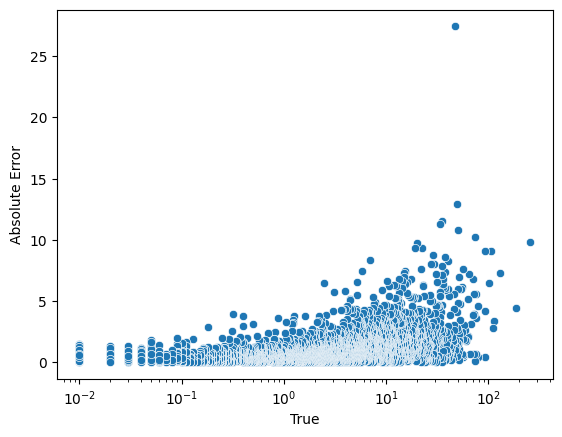

In [ ]:
sns.scatterplot(x='True', y='Absolute Error', data=results)
plt.xscale('log')

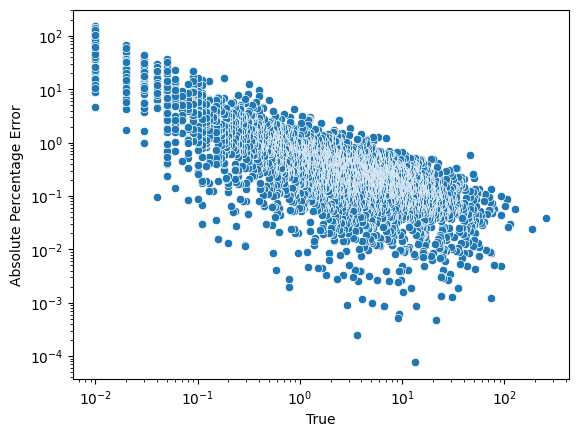

In [ ]:
sns.scatterplot(x='True', y='Absolute Percentage Error', data=results)
plt.xscale('log')
plt.yscale('log')

## Additional Data Preparation for Decision Trees

In [129]:
# Drop 'impliedVolatility' Column
scaled_df = scaled_df.drop(columns=['impliedVolatility'])

In [130]:
# Split Into Feature and Target Datasets
X = scaled_df.drop(columns=['Close'])
y = scaled_df['Close']

# Split the data into Training, Validation, and Test Sets
X_train, X_val, X_test = X[:int(0.98 * len(X))], X[int(0.98 * len(X)):int(0.99 * len(X))], X[int(0.99 * len(X)):]
y_train, y_val, y_test = y[:int(0.98 * len(y))], y[int(0.98 * len(y)):int(0.99 * len(y))], y[int(0.99 * len(y)):]

## Model 7: Decision Tree

## Model 8: Random Forest

In [122]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import numpy as np

# Define the base Random Forest Regressor model
def build_model():
    return RandomForestRegressor(random_state=42)

# Define the hyperparameter grid to search over
param_grid = {
    'n_estimators': [10, 50, 100, 500],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create the randomized search object
random_search = RandomizedSearchCV(build_model(), param_grid, cv=3, n_iter=10, scoring='neg_mean_squared_error')

# Fit the randomized search object to the data
random_search.fit(X, y)

# Get the best estimator and hyperparameters
best_model = random_search.best_estimator_
best_params = random_search.best_params_

# Evaluate the best model on the test set
from sklearn.metrics import mean_squared_error

y_pred = best_model.predict(X)
mse = mean_squared_error(y, y_pred)
print("Mean Squared Error on test set: {:.4f}".format(mse))

# Save the best model to disk
import joblib
filename = 'best_random_forest_model.pkl'
joblib.dump(best_model, filename)


KeyboardInterrupt: 

## Model 9: XGBoost

## Model 10: Binomial Asset Pricing Model